In [ ]:
!pip install PyMuPDF sentence-transformers scikit-learn

In [ ]:
import fitz
import re
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from sentence_transformers import SentenceTransformer, CrossEncoder
import torch
import torch.nn as nn

In [ ]:
embedding_model = SentenceTransformer('all-MiniLM-L6-v2')

In [4]:
def extract_text_from_pdf(pdf_path):
    doc = fitz.open(pdf_path)
    text = ""
    for page_num in range(doc.page_count):
        page = doc.load_page(page_num)
        text += page.get_text()
    return text

In [28]:
pdf_path = '/content/Welcome to the Universe_ An Astrophysical Tour ( PDFDrive.com ).pdf'

In [ ]:
pdf_text = extract_text_from_pdf(pdf_path)
documents = re.split(r'\n{1,}|\.\s|\?\s|\!\s', pdf_text)
documents = [doc.strip() for doc in documents if doc.strip()]

# Encode documents using SentenceTransformer
document_embeddings = embedding_model.encode(documents)


In [38]:
query = "Why do stars die"
query_embedding = embedding_model.encode(query)

## **1.Embedding Based Retrieval**


In [39]:
def embedding_based_retrieval():
    cosine_similarities = cosine_similarity([query_embedding], document_embeddings)[0]

    print("Documents ranked by similarity:")
    sorted_indices = np.argsort(cosine_similarities)[::-1]
    for idx in sorted_indices[:5]:  # Top 5 results
        print(f"Document: {documents[idx]}, Similarity: {cosine_similarities[idx]:.4f}")

In [40]:
embedding_based_retrieval()

Documents ranked by similarity:
Document: These stars live fast and die, Similarity: 0.7468
Document: Stars fade; last red dwarfs die, Similarity: 0.6688
Document: Not all stars live a long time, Similarity: 0.6638
Document: the lives and deaths of stars (i), Similarity: 0.6603
Document: the lives and deaths of stars (i), Similarity: 0.6603


## **2. Query Expansion**

In [41]:
def query_expansion():
    expanded_query = "endgame strategies to follow"
    expanded_query_embedding = embedding_model.encode(expanded_query)

    expanded_cosine_similarities = cosine_similarity([expanded_query_embedding], document_embeddings)[0]

    print("\nExpanded Query Results:")
    sorted_expanded_indices = np.argsort(expanded_cosine_similarities)[::-1]
    for idx in sorted_expanded_indices[:5]:
        print(f"Document: {documents[idx]}, Similarity: {expanded_cosine_similarities[idx]:.4f}")

In [42]:
query_expansion()


Expanded Query Results:
Document: During the close approach, Similarity: 0.4096
Document: make a hasty exit, Similarity: 0.3941
Document: take a step in the other direction, Similarity: 0.3693
Document: Follow the same, Similarity: 0.3687
Document: the two players must take advantage of this rule in every game where it comes, Similarity: 0.3669


## **3. Cross Encode Re-Ranking**

In [43]:
def cross_encoder_reranking():
    cross_encoder = CrossEncoder('cross-encoder/ms-marco-TinyBERT-L-6')
    cross_encoder_scores = cross_encoder.predict([[query, doc] for doc in documents])

    print("\nDocuments ranked by Cross-Encoder Re-Ranking:")
    sorted_cross_encoder_indices = np.argsort(cross_encoder_scores)[::-1]
    for idx in sorted_cross_encoder_indices[:5]:
        print(f"Document: {documents[idx]}, Score: {cross_encoder_scores[idx]:.4f}")

In [44]:
cross_encoder_reranking()

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(



Documents ranked by Cross-Encoder Re-Ranking:
Document: stars run out of hydrogen fuel and die, Score: 0.6077
Document: stars evaporate and blow away the dust surrounding them, gradually unveiling, Score: 0.2456
Document: with even one massive star, because it will become a red giant and die before, Score: 0.1949
Document: If the core of a dying star is more massive than, Score: 0.1392
Document: star collapsed to form a black hole, its interior density grew and grew until a, Score: 0.1272


## **4. Embedding Layer**

In [45]:
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA

In [46]:
class EmbeddingAdapter(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(EmbeddingAdapter, self).__init__()
        self.adapter = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        return self.adapter(x)


def embedding_adapter():
    input_dim = 384  # 'all-MiniLM-L6-v2' embedding dimension
    output_dim = 384  # Adjust as needed

    embedding_adapter_model = EmbeddingAdapter(input_dim, output_dim)

    # Convert embeddings to tensors
    document_embeddings_tensor = torch.tensor(document_embeddings)
    query_embedding_tensor = torch.tensor(query_embedding).unsqueeze(0)

    # Adapt embeddings
    adapted_document_embeddings = embedding_adapter_model(document_embeddings_tensor)
    adapted_query_embedding = embedding_adapter_model(query_embedding_tensor)

    # Convert adapted embeddings back to numpy for PCA and visualization
    adapted_document_embeddings_np = adapted_document_embeddings.detach().numpy()
    adapted_query_embedding_np = adapted_query_embedding.detach().numpy()

    # Visualize adapted embeddings with PCA
    pca = PCA(n_components=2)
    projected_dataset_embeddings = pca.fit_transform(document_embeddings)
    projected_query_embedding = pca.transform([query_embedding])
    projected_adapted_query_embedding = pca.transform(adapted_query_embedding_np)
    projected_adapted_document_embeddings = pca.transform(adapted_document_embeddings_np)

    plt.figure(figsize=(8, 6))
    plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10, color='gray', label='Documents')
    plt.scatter(projected_query_embedding[:, 0], projected_query_embedding[:, 1], s=150, marker='X', color='red', label='Original Query')
    plt.scatter(projected_adapted_query_embedding[:, 0], projected_adapted_query_embedding[:, 1], s=150, marker='X', color='green', label='Adapted Query')
    plt.gca().set_aspect('equal', 'datalim')
    plt.title("Adapted Queries")
    plt.axis('off')
    plt.legend()
    plt.show()


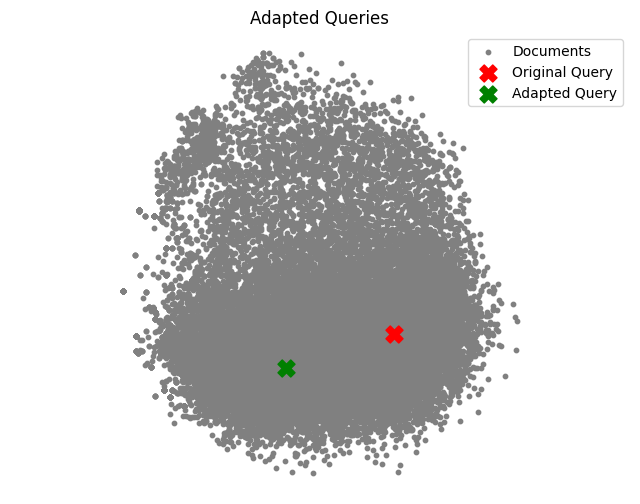

In [47]:
embedding_adapter()

## **5. ChromaDB**

In [ ]:
!pip install chromadb

In [51]:
import chromadb

client = chromadb.Client()
collection = client.create_collection(name="astrophysics_documents")

In [53]:
import fitz

def extract_text_from_pdfs(pdf_paths):
    all_text = ""
    for pdf_path in pdf_paths:
        doc = fitz.open(pdf_path)
        for page_num in range(doc.page_count):
            page = doc.load_page(page_num)
            all_text += page.get_text()
    return all_text

def process_text_to_documents(text):
    documents = text.splitlines()
    documents = [doc.strip() for doc in documents if doc.strip()]
    return documents

pdf_paths = ['/content/Welcome to the Universe_ An Astrophysical Tour ( PDFDrive.com ).pdf']  # Update paths
pdf_text = extract_text_from_pdfs(pdf_paths)
documents = process_text_to_documents(pdf_text)

In [64]:
import uuid  # Import for generating unique IDs

# Embed and store documents in ChromaDB
unique_documents = list(set(documents))
document_embeddings = embedding_model.encode(documents)

# Create unique IDs for each document
unique_ids = [str(uuid.uuid4()) for _ in range(len(documents))]


for doc, embedding, doc_id in zip(documents, document_embeddings, unique_ids):
    collection.add(
        documents=[doc],
        embeddings=[embedding.tolist()],
        metadatas=[{"text": doc}],
        ids=[doc_id]  # Include the unique ID
    )

In [ ]:
# Query embedding
query_embedding = embedding_model.encode(query).tolist()  # Convert to list

# Query ChromaDB for similar documents
results = collection.query(
    query_embeddings=[query_embedding],
    n_results=5  # Number of top results to retrieve
)

# Extract retrieved documents and their scores
retrieved_documents = results['documents'][0]
retrieved_scores = results['distances'][0]

print("Top retrieved documents:")
for doc, score in zip(retrieved_documents, retrieved_scores):
    print(f"Document: {doc}, Score: {score:.4f}")

In [66]:
reranked_docs = cross_encoder_rerank(query, retrieved_documents)

In [67]:
from transformers import GPT2Tokenizer, GPT2LMHeadModel
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
gpt2_model = GPT2LMHeadModel.from_pretrained('gpt2')

def generate_response(query, relevant_docs):
    input_text = query + "\n\n" + "\n\n".join(relevant_docs)
    inputs = tokenizer.encode(input_text, return_tensors='pt')
    outputs = gpt2_model.generate(inputs, max_length=300, num_return_sequences=1)
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

In [ ]:
final_response = generate_response(query, reranked_docs)
print("Final Response:")
print(final_response)